In [1]:
pwd

'C:\\Users\\me\\Documents\\projects\\sber-ml-intro\\notebooks\\02_linear_regression'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# эстетики ради
import seaborn as sns
sns.set() 

In [3]:
country_data = pd.read_csv('../../data/raw/country_data.csv', parse_dates = ['report_dt'])
regions_data = pd.read_csv('../../data/raw/regions_data.csv', parse_dates = ['report_dt'])

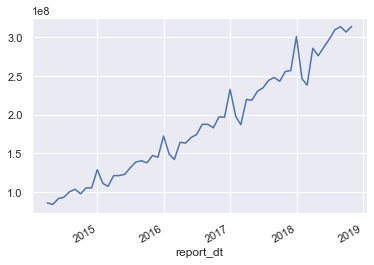

In [4]:
country = country_data[['report_dt','val']].set_index('report_dt').sort_index()\
    .squeeze()
country.plot()
plt.show()

In [5]:
regions_data.head()

,metric,Block_Id,Terr_Id,report_dt,val
0,universalis,Эпсилон,D-946,2017-07-31,110.833004
1,universalis,Эпсилон,D-946,2018-01-31,137.283747
2,universalis,Эпсилон,D-946,2017-09-30,162.325936
3,universalis,Эпсилон,D-946,2018-04-30,164.231390
4,universalis,Эпсилон,D-946,2017-08-31,176.715415


In [7]:
# из структуры таблицы region_data видно, что данные сгрупированы по полям metric, Block_Id, Terr_Id 
group_columns = ['metric', 'Block_Id', 'Terr_Id']
# а какие имеются уникальные группы?
pd.DataFrame(regions_data.groupby(group_columns).groups.keys(), columns = group_columns )

,metric,Block_Id,Terr_Id
0,universalis,Альфа,A-713
1,universalis,Альфа,A-760
2,universalis,Альфа,B-642
3,universalis,Альфа,B-785
4,universalis,Альфа,B-824
...,...,...,...
83,universalis,Эта,D-651
84,universalis,Эта,D-751
85,universalis,Эта,E-846
86,universalis,Эта,E-853


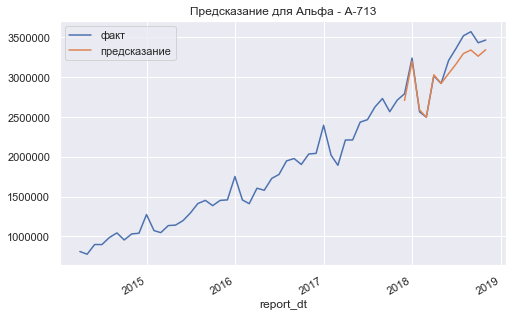

In [10]:
from sklearn.linear_model import LinearRegression

# итерируемся по сгруппированным данным
for key, region in regions_data.groupby(group_columns):
    key = dict(zip(group_columns, key)) # ключ конвертируем в словарь
    
    # преобразуем датафрейм
    region = region[['report_dt','val']].set_index('report_dt').sort_index().squeeze()
    
    # чтобы проверить качество предсказания отделяем последние 12 месяцев из факта
    validation_split = region.iloc[-12:]
    # в обучающую выборку падают все точки, за исключением имеющихся в валидационной
    train_split = region[~region.index.isin(validation_split.index)]
    
    dataset = country.to_frame('X').join(train_split.to_frame('y'))
    X_train = dataset.dropna().X.values.reshape(-1,1)
    y_train = dataset.dropna().y.values.reshape(-1,1)
    X_predict = dataset[dataset.y.isna()].X.values.reshape(-1,1)
    predict_index= dataset[dataset.y.isna()].index
    
    lr = LinearRegression().fit(X_train, y_train)
    y_predict = lr.predict(X_predict).flatten()
    prediction = pd.Series(data = y_predict, index = predict_index)
    
    region.plot(title = 'Предсказание для %s - %s' % (key['Block_Id'], key['Terr_Id']), 
                label='факт', figsize = (8,5))
    prediction.plot(label = 'предсказание')
    plt.legend()
    plt.show()

    break # разберемся пока с одной итерацией далее

# Как измерить качество предсказания?
__Regression Metrics:__
+ Mean Squared Error (MSE)
+ Root Mean Squared Error (RMSE)
+ Mean Absolute Error (MAE)
+ R Squared (R²)
+ Adjusted R Squared (R²)
+ Mean Square Percentage Error (MSPE)
+ Mean Absolute Percentage Error (MAPE)
+ Root Mean Squared Logarithmic Error (RMSLE)

Например прогнозируем количество произведенных яиц на птицефабрике в следующем месяце: 14000
По факту производится 15300
Как посчитать насколько ошиблись?

Самое простое вычесть из факта прогноз: 14000 - 15300 = -1300 (занизили прогноз на 1300)
Но если бы строили прогноз по нескольким месяцам, то для оценки стоило бы взять среднюю погрешность.
В таком случае отрицательные значения не позволят корректно вычислить среднее значение.
Поэтому добавляем модуль в формулу расчета ошибки: |14000 - 15300| = 1300
Так изобрели MAE (Mean Absolute Error)

In [ ]:
Но 1300 это много или мало в целом для прогнозируемой величины? 
Посчитаем в процентном отношении: |14000/15300 -1| = 0.084 = 8.4% 
    (фактическое значение всегда внизу. мнемоника: факт он как фундамент - надёга, поэтому внизу)
Если прогнозируем несколько месяцев, то тогда среднее значение по всем ошибкам приведет к оценке точности,
которую называют MAPE - Mean Absolute Percent Error

Если бы мы прогнозировали население городов и подбирали лучшую модель, то при использовании MAE, RMSE 
и прочих метрик основанных на абсолютных значениях модель хорошо бы прогнозировала Москву, а какой-нибудь мелкий
город прогнозировался с большой ошибкой

MAPE позволяет справедливо прогнозировать каждый город, т.к. мы ориентируемся на относительную точность модели
для каждого набора данных
    

$$ Absolute Percent Error = \left|\frac{\hat{y}_i}{y_i}-1\right|$$

$$MAPE = \frac{100}{n} \sum_i ^n \frac{y_i - \hat{y}_i}{y_i}$$

In [17]:
abs(prediction/validation_split-1) # Absolute Percent Error для каждой точки прогнозируемой даты

report_dt
2017-11-30    0.029917
2017-12-31    0.012432
2018-01-31    0.009477
2018-02-28    0.000314
2018-03-31    0.003900
2018-04-30    0.000347
2018-05-31    0.051514
2018-06-30    0.058145
2018-07-31    0.063233
2018-08-31    0.064541
2018-09-30    0.049090
2018-10-31    0.035045
dtype: float64

In [18]:
# MAPE
abs(prediction/validation_split-1).mean() # относительная точность прогнозирования для одной группы 

0.03149646177301927

# Выпускайте Кракена!

In [26]:
# вот такой ответ хочется получить на выходе
validation_split.to_frame('actual')\
    .join(prediction.to_frame('prediction'))\
    .join(abs(prediction/validation_split-1).to_frame('error')).assign(**key)

,actual,prediction,error,metric,Block_Id,Terr_Id
report_dt,,,,,,
2017-11-30,2790377.979,2.706900e+06,0.029917,universalis,Альфа,A-713
2017-12-31,3239002.244,3.198733e+06,0.012432,universalis,Альфа,A-713
2018-01-31,2564333.464,2.588637e+06,0.009477,universalis,Альфа,A-713
2018-02-28,2497046.450,2.496262e+06,0.000314,universalis,Альфа,A-713
2018-03-31,3016259.965,3.028024e+06,0.003900,universalis,Альфа,A-713
2018-04-30,2919970.860,2.920985e+06,0.000347,universalis,Альфа,A-713
2018-05-31,3209237.245,3.043915e+06,0.051514,universalis,Альфа,A-713
2018-06-30,3356258.518,3.161109e+06,0.058145,universalis,Альфа,A-713
2018-07-31,3518274.188,3.295803e+06,0.063233,universalis,Альфа,A-713


In [28]:
from sklearn.linear_model import LinearRegression

predictions = []
# итерируемся по сгруппированным данным
for key, region in regions_data.groupby(group_columns):
    key = dict(zip(group_columns, key)) # ключ конвертируем в словарь
    
    # преобразуем датафрейм
    region = region[['report_dt','val']].set_index('report_dt').sort_index().squeeze()
    
    # чтобы проверить качество предсказания отделяем последние 12 месяцев из факта
    validation_split = region.iloc[-12:]
    # в обучающую выборку падают все точки, за исключением имеющихся в валидационной
    train_split = region[~region.index.isin(validation_split.index)]
    
    dataset = country.to_frame('X').join(train_split.to_frame('y'))
    X_train = dataset.dropna().X.values.reshape(-1,1)
    y_train = dataset.dropna().y.values.reshape(-1,1)
    X_predict = dataset[dataset.y.isna()].X.values.reshape(-1,1)
    predict_index= dataset[dataset.y.isna()].index
    
    lr = LinearRegression().fit(X_train, y_train)
    y_predict = lr.predict(X_predict).flatten()
    prediction = pd.Series(data = y_predict, index = predict_index)
    
    result = validation_split.to_frame('actual')\
    .join(prediction.to_frame('prediction'))\
    .join(abs(prediction/validation_split-1).to_frame('error')).assign(**key)
    
    predictions += result.to_dict('r')    

In [42]:
predictions_df = pd.DataFrame(predictions).groupby(group_columns).error.mean().reset_index()
predictions_df

,metric,Block_Id,Terr_Id,error
0,universalis,Альфа,A-713,0.031496
1,universalis,Альфа,A-760,0.015332
2,universalis,Альфа,B-642,0.014832
3,universalis,Альфа,B-785,0.024319
4,universalis,Альфа,B-824,0.054348
...,...,...,...,...
83,universalis,Эта,D-651,0.018234
84,universalis,Эта,D-751,0.037173
85,universalis,Эта,E-846,0.014106
86,universalis,Эта,E-853,0.008730


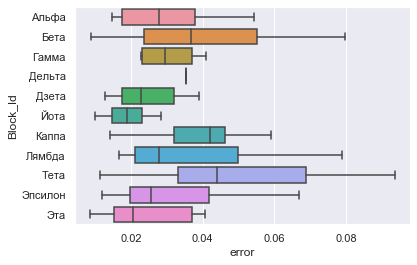

In [66]:
sns.boxplot(
    y='Block_Id', 
    x='error',
    data = predictions_df,  
    showfliers = False # если убрать, то всё испортит одна плохая территория
)

In [37]:
pd.DataFrame(predictions).groupby(group_columns).error.mean().sort_values()

metric       Block_Id  Terr_Id
universalis  Эта       E-853       0.008730
             Бета      B-679       0.008986
             Йота      C-720       0.009969
             Тета      F-755       0.011461
             Эпсилон   B-773       0.012038
                                    ...    
             Лямбда    F-850       0.078736
             Бета      C-691       0.079551
             Эпсилон   A-973       0.082604
             Тета      B-791       0.093533
             Эпсилон   D-946      13.832572
Name: error, Length: 88, dtype: float64

In [39]:
pd.DataFrame(predictions).groupby(group_columns).error.mean().sort_values().mean()

0.19052717178050918

In [41]:
# разница между средним и медианой существенное! 
# (именно поэтому нужны глав.врачи с миллионными зарплатами, чтобы увеличивать среднюю зп в больнице)
pd.DataFrame(predictions).groupby(group_columns).error.mean().sort_values().median()

0.029320368188855847